## Context

You work for the road safety team within the department of transport and are looking into how they can reduce the number of major incidents. The safety team classes **major incidents** as **fatal accidents involving 3+ casualties**. They are trying to learn more about the characteristics of these major incidents so they can brainstorm interventions that could lower the number of deaths. They have asked for your assistance with answering a number of questions.

The reporting department have been collecting data on every accident that is reported. They've included this along with a lookup file for 2020's accidents.

*Published by the department for transport. https://data.gov.uk/dataset/road-accidents-safety-data* 
*Contains public sector information licensed under the Open Government Licence v3.0.*

### We are looking to answer the following questions:

1. What **time of day and day of the week** do most major incidents happen?
2. Are there any **patterns in the time of day/ day of the week** when major incidents occur?
3. What **characteristics** stand out **in major incidents** compared with other accidents?
4. On **what areas** would you recommend the planning team **focus** their brainstorming **efforts to reduce major incidents**?

## Analysis Summary

The dataset includes **91,199 total accidents**, out of which **202 were major accidents** (0.22%).

Let's recap the questions we are trying to answer:

1. What **time of day** and **day of week** do most major accidents happen?

- For the day of the week when most major accidents happen, the short answer is **Saturday**
- While for the total accidents we can see a progression throughout the week (an increasing number of accidents from Monday-Friday, with a drop at the beginning of the weekend), the major accidents don't follow an obvious pattern. Saturday stands out as the day with the most major accidents.

<img src='Accidents_by_day_of_week.png' width="400" height="500">

2. Are there any **patterns** in the **time of day/ day of the week** when major incidents occur?

- Looking at the hour, we can see that **major accidents** happen mostly **during evening and late evening hours**

<img src='Percentage_Major_hour.png' width="600" height="700">

- And below we go into a more detailed view, looking at **day and hour**. We can see the pattern of evening/late evening major accidents emerging especially **on Saturday**:

<img src='Major_Accidents_day_hour.png' width="1200" height="500">

- On the other hand, **all the accidents counted together (major + non-major)** follow a curve. When we look at the number of accidents per hour, we can distinguish **2 peaks** - the highest one during the afternoon "rush hour" around 3 pm-6 pm and a smaller one during the morning "rush hour" (8 am).
- A 2017 bbc article (https://www.bbc.com/news/uk-england-42917201) mentions that the Department of Transport classed the rush hours in England as between 6-9 am  and 4-7 pm on weekdays, which mostly aligns with our plot by hourly intervals.

<img src='Percentage_TotalAccidents_hour.png' width="600" height="700">

3. What **characteristics** stand out in **major incidents** compared with other accidents?

We performed a Chi-Square Test of independence to see if there is a statistically significant association between the occurence of a major vs other accident and various conditions present at the time of the accident. 

The factors that stand out in major accidents, while also being stastistically significant are:

- **light conditions**: approx 40% of major accidents occur in conditions of **darkness (no lighting and lights lit)**, as opposed to only approx 25% of non-major accidents
- **road surface conditions**: more than 40% major accidents occur on **wet/damp roads**, as opposed to under 30% of other accidents
- **urban vs rural area**: close to 80% of major accidents occur in **rural areas**, as opposed to under 30% of other accidents
- **junction detail**: approx 70% of major accidents occur **not at junction or within 20 meters**, as opposed to approx 40% of other accidents
- **pedestrian crossing**: more than 90% of major accidents occur in areas with **no physical crossing within 50 meters**, as opposed to under 80% of other accidents
- **speed limit**: close to 50% of major accidents occur in areas with **60 km speed limit**, while the majority of other accidents occur in areas with 30 km speed limit. Speed limit is also highly correlated with urban/rural area

4. On **what areas** would you recommend the planning team **focus** their brainstorming **efforts to reduce major incidents**?

As we can see throughout the analysis, major accidents don't follow a predictable curve as non-major accident do, but we did find a few significant factors: most major accidents happen after dark, predominantly on Saturday, in rural areas (mostly with 60 km speed limit) and they tend to happen more often in wet/damp conditions.

Therefore a few areas where the planning team could focus their attention could be:
- improving visibility after dark in rural areas, if possible
- sending traffic enforcement teams at specific days and times (ex: Saturday evening/night), in poorly lit areas with higher speed limits, especially during poor weather conditions
- revisiting the speed limit in areas with multiple accidents
- checking for a correlation with driving under influence, especially on weekend nights and considering public service campaigns that might change that behaviour

### Load packages and data

In [61]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # for formatting ticks on sns charts
from scipy.stats import chi2_contingency # for chi-square tests

In [62]:
# read the accidents file
accidents = pd.read_csv(r'./data/accident-data.csv')
# read the lookup file
lookup = pd.read_csv(r'./data/road-safety-lookups.csv')

In [63]:
# renamed one column in the lookup df to match the accidents df
lookup.rename(columns= {"Latitude":"latitude"},inplace=True)

### Data Setup and Exploratory Data Analysis

There are a few nulls in the longitute and latitude columns and according to the lookup table we have nulls for unknowns values

In [64]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   accident_index                           91199 non-null  object 
 1   accident_year                            91199 non-null  int64  
 2   accident_reference                       91199 non-null  object 
 3   longitude                                91185 non-null  float64
 4   latitude                                 91185 non-null  float64
 5   accident_severity                        91199 non-null  int64  
 6   number_of_vehicles                       91199 non-null  int64  
 7   number_of_casualties                     91199 non-null  int64  
 8   date                                     91199 non-null  object 
 9   day_of_week                              91199 non-null  int64  
 10  time                                     91199

### Data Preparation

Added new columns to the accidents dataframe to support the analysis.
This way we can quickly identify **202 major accidents** out of a **total of 91,199 total accidents**.

In [65]:
# create an "hour" column to better calculate the number of accidents based on hour intervals
accidents['hour'] = pd.to_datetime(accidents['time'], format='%H:%M').dt.hour

# create a "month" column to see the evolution of the number of accidents month by month
accidents['month'] = pd.to_datetime(accidents['date']).dt.month  

#create a "weekend" column to identify the weekends
accidents['weekend'] = "No"
accidents.loc[(accidents.day_of_week==1) & (accidents.day_of_week==6),'weekend'] = "Yes"

# create a "major accident" column to identify major accidents - "yes"/"no" values
accidents['major_accident'] = "No"
accidents.loc[(accidents.number_of_casualties>=3) & (accidents.accident_severity==1), 'major_accident'] = "Yes"

# isolating major accidents in a dataframe, based on accident severity (fatal) and number of casualties (>=3)
major_accidents = accidents[(accidents.number_of_casualties>=3) & (accidents.accident_severity==1)]

# how many major accidents are in the database?
accidents['major_accident'].value_counts()   

No     90997
Yes      202
Name: major_accident, dtype: int64

### Analysis of Total Number of Accidents by Month

We'll first start with an overview of the number of accidents by month, and then move on to an analysis at the week level.

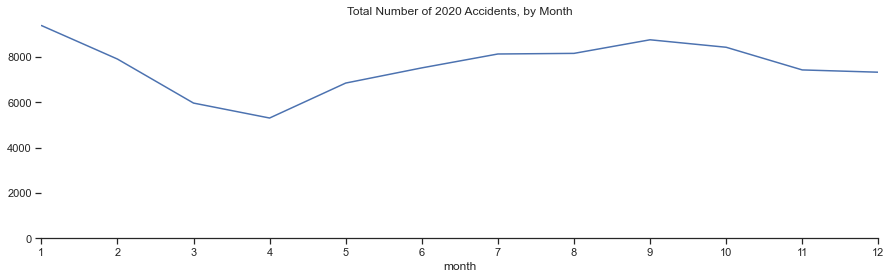

In [66]:
# grouped all the accidents by month
accidents_by_month = accidents.groupby('month')['accident_index'].size().reset_index().rename(columns = {'accident_index':'number_of_accidents'})

sns.set(rc={"figure.figsize":(15, 4)}, style="ticks")

# line plot of the total number of accidents, by month
g = sns.lineplot(x='month',y='number_of_accidents',data=accidents_by_month)

# chart setup
g.set(ylim=(0,None),xlim=(1,12))
g.set(ylabel=None)
g.set(xticks=accidents_by_month.month.values)
g.set(title = "Total Number of 2020 Accidents, by Month")

sns.despine(left="True")

**April 2020** is the month with the **lowest number of accidents**. Itwas the sunniest April on record for the UK, according to a provisional analysis of the month's climate statistics by the Met Office.
Also, the world wide COVID-19 pandemic brougth travel restrictions and working from home, which contributed to reduced traffic during that period of time.

Confirming correlation between traffic and number the of accidents would be the subject of further analysis, involving traffic data.
We'll continue to analyze the correlation between weather conditions and accidents based on the data we have.

In [67]:
# grouped the data by major accidents and other accidents - by month
# calculated the percentage of total accidents for each of the groups, by month
group_other = accidents[accidents['major_accident']=="No"].groupby('month')['accident_index'].agg(pct_other_accidents ='size').apply(lambda x: 100*x/float(x.sum())).reset_index().set_index('month')
group_major = accidents[accidents['major_accident']=="Yes"].groupby('month')['accident_index'].agg(pct_major_accidents ='size').apply(lambda x: 100*x/float(x.sum())).reset_index().set_index('month')

In [68]:
# joined them and then melted the final dataframe (to enable plotting 2 lines on one chart)
group_pct = group_other.join(group_major)
group_pct.reset_index(inplace=True)
group_pct = group_pct.melt('month',var_name='cols', value_name='vals')

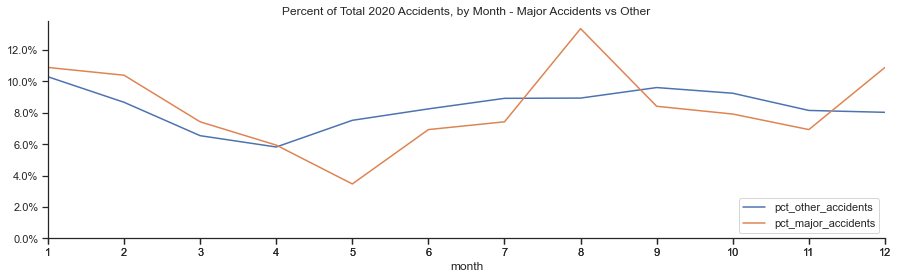

In [69]:
sns.set(rc={"figure.figsize":(15, 4)}, style="ticks")
g = sns.lineplot(x='month',y='vals',hue='cols',data=group_pct)

g.set(ylim=(0,None),xlim=(1,12),ylabel=None,xticks=group_pct.month.values,title = "Percent of Total 2020 Accidents, by Month - Major Accidents vs Other")
g.yaxis.set_major_formatter(mtick.PercentFormatter())
g.legend(loc='lower right')

sns.despine()

When comparing major accidents with non-major ones, we see that the 2 peaks for the majors accidents are in:
- **May: lowest** number of major accidents
- **August: highests** number of major accidents

For non-major accidents, the month-to-month differences are not as significant.

### Analysis of accidents by the day of the week

In [70]:
def colors_from_values(values, palette_name):
    ''' a function used to set a changing color palette based on continuous values in the sns plots'''
    
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

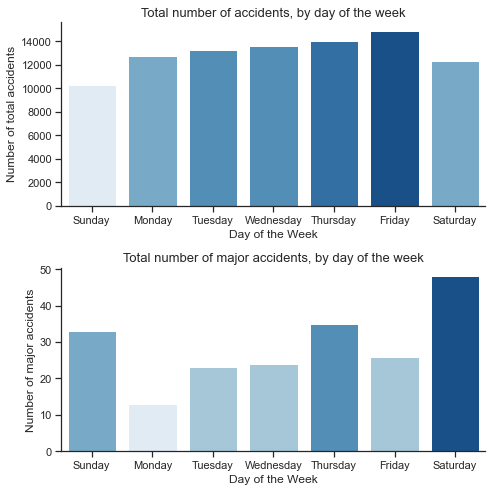

In [71]:
lookup_labels = lookup[lookup['field name'] == 'day_of_week'].label.values
values_all = accidents[accidents['major_accident']=="No"].groupby('day_of_week').size()
values_major = major_accidents.groupby('day_of_week').size()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(7,7),tight_layout=True)
sns.countplot(data = accidents,x="day_of_week", palette = colors_from_values(values_all,"Blues"),ax=ax1)
ax1.set_title("Total number of accidents, by day of the week",fontsize=13)
ax1.set(
        xlabel = 'Day of the Week', 
        ylabel = 'Number of total accidents',
        )
ax1 = ax1.set_xticklabels(lookup_labels)

sns.countplot(data = major_accidents,x="day_of_week",palette = colors_from_values(values_major,"Blues"),ax=ax2)
ax2.set_title("Total number of major accidents, by day of the week",fontsize=13)
ax2.set(
        xlabel = 'Day of the Week', 
        ylabel = 'Number of major accidents',
        )
ax2 = ax2.set_xticklabels(lookup_labels)
sns.despine()
plt.show()
fig.savefig('Accidents_by_day_of_week.png')


When we group the total number of accidents by day, there is a noticeable difference between the number of accidents during **weekdays vs weekends**.

In the first chart above we can see that Friday is the day with the highest number of accidents, while Sunday has the lowest number of accidents.

We can also notice an **increasing day-to-day trend in the number of accidents as the work week progresses** (Monday to Friday), and their number drops at the beginning of the weekend.

For the **major accidents**, the situation is different - Saturday is the day with the most major incidents, while Monday is the day with the least number of major accidents.
There is no obvious pattern noticeable throughout the week.

In [72]:
def plot_month_day(data):
   
    accidents_month_day = data.groupby(['month','day_of_week'])['accident_index'].size().reset_index(name="number_of_accidents")
    
    # calculated the percentage of accidents per day and per hour out of the total number of accidents
    accidents_month_day['number_of_accidents_pct'] = accidents_month_day.number_of_accidents/accidents_month_day.number_of_accidents.sum()
    
    g = sns.FacetGrid(accidents_month_day, col = "month",col_wrap = 6,height = 4)
    g.map(plt.bar,"day_of_week","number_of_accidents_pct")  
   
    # Titles set based on the the lookup table for individual charts
    #lookup_labels = lookup[lookup['field name'] == 'month'].label.values
    month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
    axes = g.axes.flatten()
    for i in range(0,len(month_labels)):
        axes[i].set_title(month_labels[i],fontsize=12)

In [73]:
#plot_month_day(accidents)

If we break the number of accidents/day down to month by month level, the work week Monday to Friday slow increase is not as apparent anymore when we look at all accidents.

2020 has also been a unique year, with a never before seen influence from the COVID19 pandemic that changed the way people travel and drastically reduced traffic during lockdowns.

In England, the first lockdowns of the year were between March 16 - April 30 (https://www.instituteforgovernment.org.uk/sites/default/files/timeline-lockdown-web.pdf), which is reflected in the low number of accidents in March and April compared to the rest of the year.
The second one was in November - again we see here a drop in the total number of accidents compared to the rest of the year.

Of course, correlation does not imply causation, but it's a plausible hypothesis that could be explored.

In [74]:
def plot_month_date(data):
   
    accidents_month_day = data.groupby(['month','date','major_accident'])['accident_index'].size().reset_index(name="number_of_accidents")
    
    # calculated the percentage of accidents per day and per hour out of the total number of accidents
    accidents_month_day['number_of_accidents_pct'] = accidents_month_day.number_of_accidents/accidents_month_day.number_of_accidents.sum()
    
    g = sns.FacetGrid(accidents_month_day, col = "month",col_wrap = 3,height = 2.5,aspect=3)
    g.map_dataframe(sns.lineplot,"date","number_of_accidents_pct",hue="major_accident") 
    g.set(yscale='log')

    g.set_xticklabels(list(range(1,31+1)))
    
    sns.despine()
   
    # Titles set based on the the lookup table for individual charts
    #lookup_labels = lookup[lookup['field name'] == 'month'].label.values
    month_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
    axes = g.axes.flatten()
    for i in range(0,len(month_labels)):
        axes[i].set_title(month_labels[i],fontsize=12)

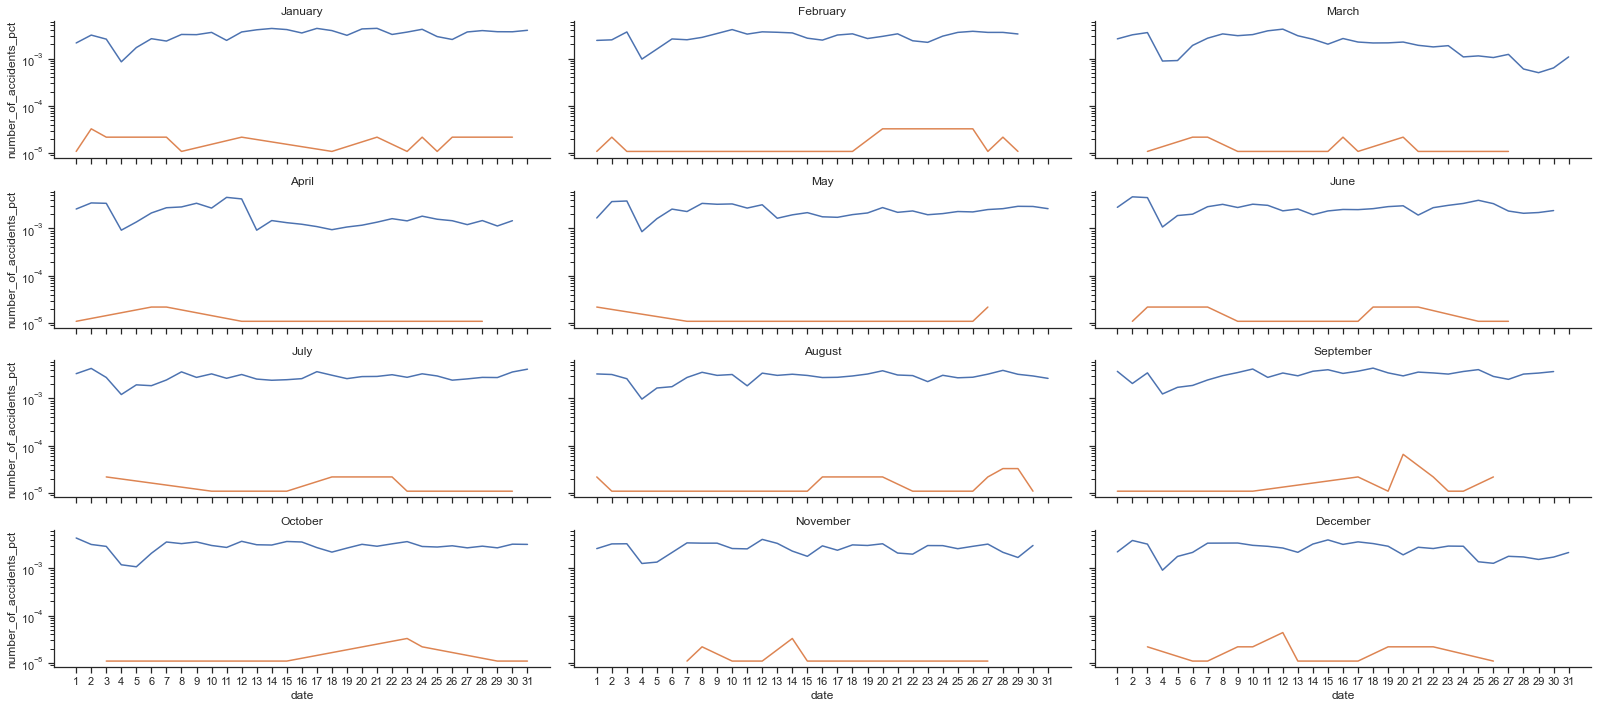

In [75]:
plot_month_date(accidents)

## Analysis of Accidents by Time of Day

We will first have a look at the number of accidents by time of day and look for patterns that we may encounter for major accidents.

In [76]:
# grouped the accidents table and the major accidents table by time
accidents_time = accidents.groupby(['time'])['accident_index'].count().reset_index().set_index('time').rename(columns = {'accident_index':'number_of_accidents'})
major_accidents_time = major_accidents.groupby(['time'])['accident_index'].count().reset_index().set_index('time').rename(columns = {'accident_index':'number_of_major_accidents'})

# created a table that includes the total number of accidents, 
# as well as the number of major accidents, by timestamp
accidents_time = accidents_time.join(major_accidents_time)

In [77]:
# add a flag column for major accidents
accidents_time['includes_major'] = "No"
accidents_time.loc[accidents_time.number_of_major_accidents.notnull(),"includes_major"] = "Yes"

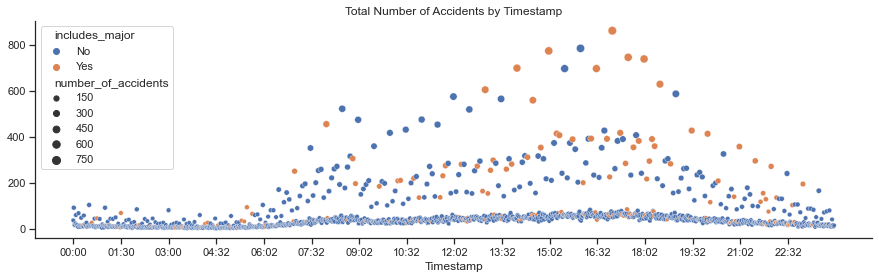

In [78]:
sns.set(rc={"figure.figsize":(15, 4)}, style="ticks")
g = sns.scatterplot(accidents_time.index,accidents_time.number_of_accidents,hue = accidents_time.includes_major,size=accidents_time.number_of_accidents)
g.set(xticks = accidents_time.index[0::90])
g.set(ylabel=None,xlabel="Timestamp")
plt.title("Total Number of Accidents by Timestamp")
sns.despine()
plt.show()

The scatterplot above includes all the time data in our table, at the lowest level of granularity (the timestamps aren't grouped by any category). We're looking exclusively at timestamps and how often they each appear in the dataset.

We can notice a **pattern of a high number of accidents within peak traffic hours** - the major one during the afteroon peak (end of workday) and another smaller one in the morning.

The orange dots represent times when major accidents (also) occured, most of the times being counted together with other accidents. We can't make a clear distinction though between patterns for total acccidents versus major accidents at this stage. We'll investigate further by looking at major accidents vs other accidents by hourly intervals.

In [79]:
def accidents_by_hour(data,title,chart_title):
    '''this function groups the data by hour and aggregates it by the number of accidents. 
    Returns a barplot of the results'''
    
    accidents_hour = data.groupby('hour')['accident_index'].count().reset_index().rename(columns = {'accident_index':'number_of_accidents'})
    accidents_hour['number_of_accidents_pct'] = accidents_hour.number_of_accidents*100/accidents_hour.number_of_accidents.sum()
    
    values = accidents_hour.number_of_accidents_pct

    g = sns.barplot(accidents_hour.hour,accidents_hour.number_of_accidents_pct, palette= colors_from_values(values,"Blues"))
    
    g.set(ylabel=None)
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    sns.despine(bottom="True")
    plt.title(title)
    plt.show()
    g.figure.savefig(chart_title+".png")
    

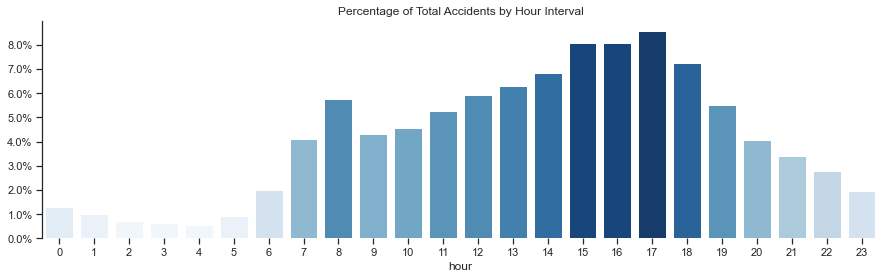

In [80]:
accidents_by_hour(accidents,"Percentage of Total Accidents by Hour Interval", "Percentage_TotalAccidents_hour")

When we look at the number of accidents per hour, we can distinguish **2 peaks** - the highest one during the afternoon "rush hour" around 3 pm-6 pm and a smaller one during the morning "rush hour" (8 am).

A 2017 bbc article (https://www.bbc.com/news/uk-england-42917201) mentions that the Department of Transport classed the rush hours in England as between 6-9 am  and 4-7 pm on weekdays, which mostly aligns with our plot by hourly intervals. The morning accident peak seems to be towards the end of the rush hour interval, which could make sense from a human patience perspective (people stuck in traffic for a long time and being late for work, which can lead to unwise driving decisions). Again, a hypothesis like this would need to be tested.
  

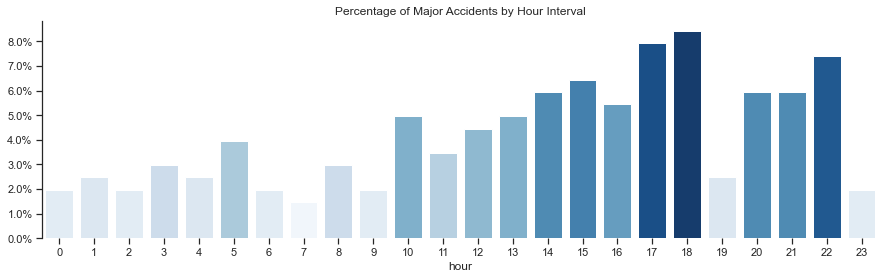

In [81]:
accidents_by_hour(major_accidents,"Percentage of Major Accidents by Hour Interval","Percentage_Major_hour")

When we isolate major accidents however, the pattern changes - we notice a late afternoon peak and a late evening peak. 

For most of the year, this evening time interval (8-10  pm) will be an interval with no natural light. During fall and winter, the 5-6 pm time interval will aslo be a time with no daylight. We will look later in the analysis at the connection between major accidents and ligthing conditions.

In [82]:
# making sure that the lookup table is sorted by field name and code/format, to enable proper matching between codes and their labels
lookup.sort_values(['field name','code/format'],inplace=True)

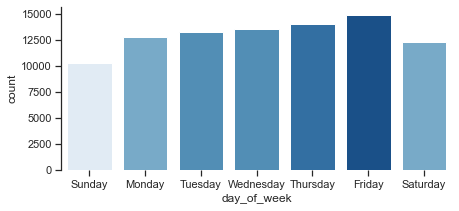

In [83]:
sns.set(rc={"figure.figsize":(7, 3)}, style="ticks")
values = accidents[accidents['major_accident']=="No"].groupby('day_of_week').size()
g = sns.countplot(data = accidents,x="day_of_week", palette = colors_from_values(values,"Blues"))

lookup_labels = lookup[lookup['field name'] == 'day_of_week'].label.values
g = g.set_xticklabels(lookup_labels)
sns.despine(bottom="True")

After noticing how the accidents by hour are at their highest around peak traffic hours, let's take a step back and have a look at the total number of accidents grouped by the day of the week.

As expected, there is a **noticeable difference** between the number of accidents during **weekdays vs weekends**.

In the chart above we can see that **Friday is the day with the highest number of accidents**, while **Sunday has the lowest number of accidents**.

We can also notice an **increasing day-to-day trend in the number of accidents as the work week progresses** (Monday to Friday), and their number drops at the beginning of the weekend.

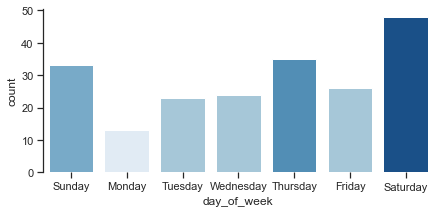

In [84]:
values = major_accidents.groupby('day_of_week').size()
g = sns.countplot(data = major_accidents,x="day_of_week",palette = colors_from_values(values,"Blues"))

lookup.sort_values(['field name','code/format'],inplace=True)
lookup_labels = lookup[lookup['field name'] == 'day_of_week'].label.values
g = g.set_xticklabels(lookup_labels)
sns.despine(bottom="True")


The situation is different when we look exclusively at the major accidents. 
Saturday is the day when the most major accidents happened, while Monday is the day with the lowest number of major accidents.

In [85]:
# Group dataframe by day of the week and then by hour. 
# Show top 5 hours/day with the highest number of accidents

accidents_day_hour = accidents.groupby(['day_of_week','hour'])['accident_index'].size().reset_index(name="number_of_accidents")
accidents_day_hour['number_of_accidents_pct'] = accidents_day_hour.number_of_accidents/accidents_day_hour.number_of_accidents.sum()
accidents_day_hour.head(3)

,day_of_week,hour,number_of_accidents,number_of_accidents_pct
0,1,0,306,0.003355
1,1,1,226,0.002478
2,1,2,170,0.001864


In [86]:
def plot_day_hour(data,chart_title):
   
    accidents_day_hour = data.groupby(['day_of_week','hour'])['accident_index'].size().reset_index(name="number_of_accidents")
    
    # calculated the percentage of accidents per day and per hour out of the total number of accidents
    accidents_day_hour['number_of_accidents_pct'] = accidents_day_hour.number_of_accidents/accidents_day_hour.number_of_accidents.sum()
         
    g = sns.FacetGrid(accidents_day_hour, col = "day_of_week", height = 8)
    g.map(plt.bar,"hour","number_of_accidents_pct")
    g.set_xlabels("Hour",fontsize=25)
    g.set_ylabels("Percent of Total Accidents",fontsize=25)
    #g.axes.set_major_formatter(mtick.PercentFormatter())
   
    # Titles set based on the the lookup table for individual charts
    lookup_labels = lookup[lookup['field name'] == 'day_of_week'].label.values
    axes = g.axes.flatten()
    for i in range(0,len(lookup_labels)):
        axes[i].set_title(lookup_labels[i],fontsize=25)
    g.savefig(chart_title+'.png')

The plots below show the accident data grouped by day and then by hourly interval.

#### All accidents
- The first set of plots represents all accidents - we can see how the number of accidents evolves during the week - starting from **Sunday**, with a flatted curve and the **lowest number of accidents overall**.

- From **Monday to Friday** we notice the trend we noticed before when we looked at the total number of accidents by day of week - **as the week progresses the rush hour peaks gain height**, as the number of accidents slightly increases day-by-day.

- **Saturday we have a drop in the number of accidents** - we don't have anymore rush hour peaks, just **a steady number of hourly accidents within daytime hours**.

#### Major accidents

- Major accidents don't follow the same pattern - or any obvious pattern. What is clear is again the fact that on **Saturdays we have the highest number of accidents**, especially during **evening and late evening hours**.
- Monday is the day with the least number of major accidents.

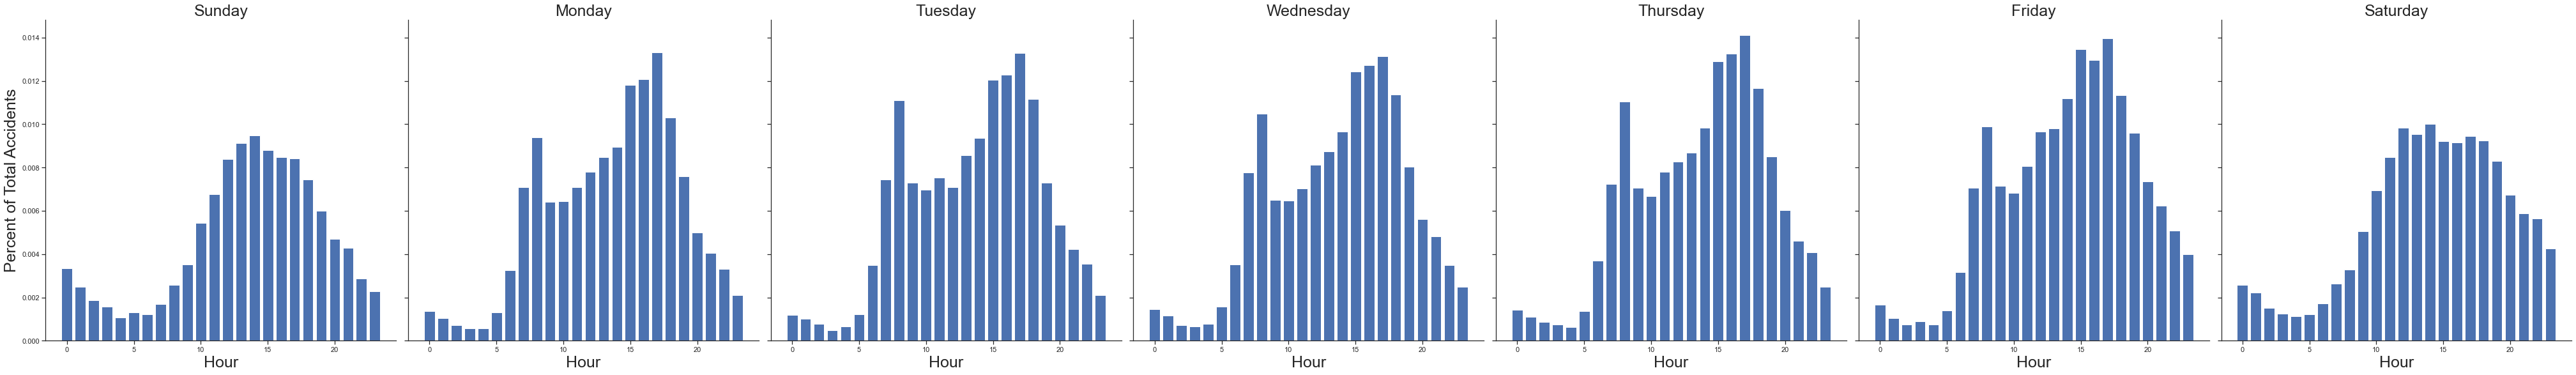

In [87]:
plot_day_hour(accidents,'All_Accidents_day_hour')

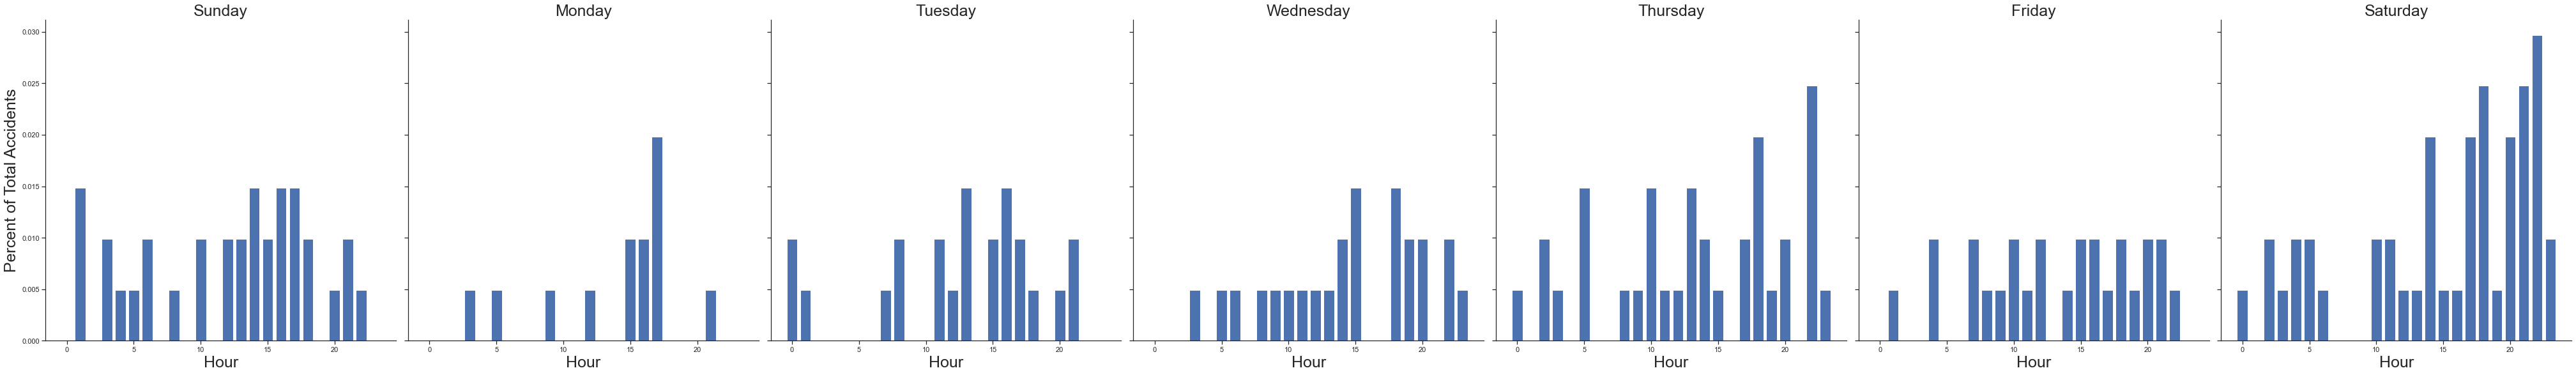

In [88]:
plot_day_hour(major_accidents,'Major_Accidents_day_hour')

## Characteristics of Major Incidents Compared to Other Accidents

We'll start with a correlation plot, to see if there is any correlation between some of the environmental conditions or infrastructure/traffic controls and the incidence of major accidents.

Then we'll run a Chi Square test to see if the findings are statistically significant.

In [89]:
corr_columns = accidents[['major_accident',
                          'number_of_vehicles',
                         'day_of_week', 
                         'time',
                         'first_road_class', 
                         'road_type', 
                         'speed_limit',
                         'junction_detail', 
                         'junction_control', 
                         'second_road_class',
                         'pedestrian_crossing_human_control',
                         'pedestrian_crossing_physical_facilities', 
                         'light_conditions',
                         'weather_conditions', 
                         'road_surface_conditions',
                         'special_conditions_at_site', 
                         'carriageway_hazards',
                         'urban_or_rural_area',                          
                         ]]

In [90]:
corr_columns['major_accident'] = np.where(corr_columns.major_accident == "Yes",1,0)

<AxesSubplot:>

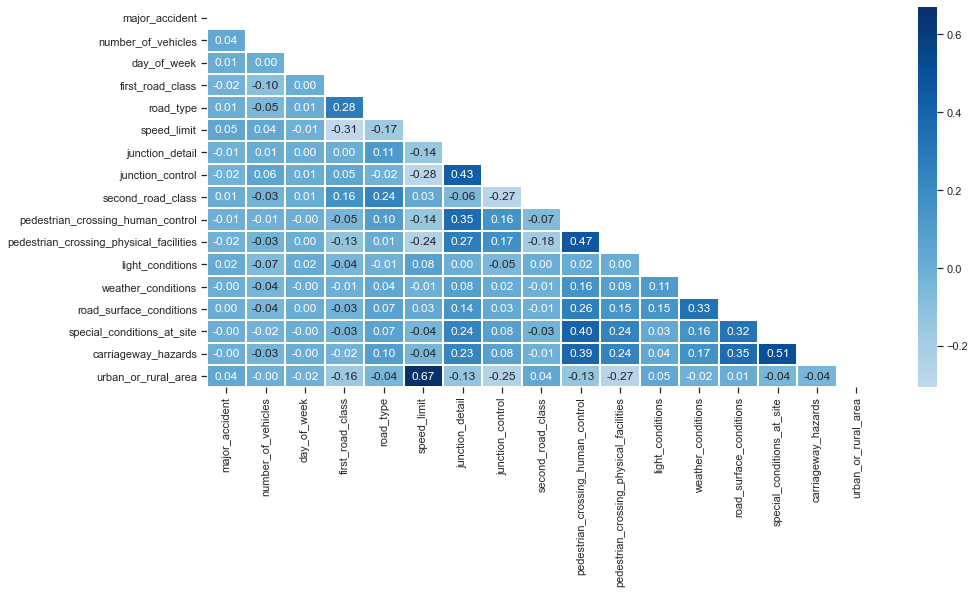

In [91]:
#corr = corr_columns.corr()
#corr.style.background_gradient(cmap='coolwarm')
sns.set(rc={"figure.figsize":(15, 7)}, style="ticks")
corr_matrix = corr_columns.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
sns.heatmap(corr_columns.corr(),annot=True,cmap="Blues",center=0, linewidths=1, fmt=".2f",mask=mask)

From the heatmap above we can notice a slight correlation between major accidents and urban and rural area and speed limit, as well as light conditions, pedestrian crossings, and junction control.
Let's calculate them individually

#### Chi Square Analysis Setup
##### - is there a difference between the occurence of major accidents vs regular accidents under various conditions?

The chi-square test provides a method for testing the association between the row and column variables in a two-way table. The null hypothesis assumes that there is no association between the variables (in other words, one variable does not vary according to the other variable), while the alternative hypothesis claims that some association does exist. 

The chi-square test is based on a test statistic that measures the divergence of the observed data from the values that would be expected under the null hypothesis of no association (if everything happened by chance - even if two variables are independent in the population, samples will vary due to random sampling variation).

Below we have an example of a two-way table for measuring the association between light conditions and the occurence of major accidents vs other accidents:

In [92]:
group = accidents.groupby(['major_accident','light_conditions'])['accident_index'].agg(number_of_accidents ='count').reset_index()
pd.crosstab(group.major_accident,group.light_conditions,values=group.number_of_accidents,aggfunc='sum',margins=True,dropna=False).fillna(0)

light_conditions,-1,1,4,5,6,7,All
major_accident,,,,,,,
No,1.0,64337.0,18992.0,683.0,4790.0,2194.0,90997
Yes,0.0,121.0,34.0,2.0,45.0,0.0,202
All,1.0,64458.0,19026.0,685.0,4835.0,2194.0,91199


In [93]:
chisqt = pd.crosstab(group.major_accident,group.light_conditions,values=group.number_of_accidents,aggfunc='sum',margins=True,dropna=False).fillna(0)
value = np.array([chisqt.iloc[0][0:5].values,
                 chisqt.iloc[1][0:5].values])
chi2_contingency(value)[0:3]

(112.22186771664501, 2.4437136378938934e-23, 4)

In [94]:
def chi_test(data,column):
    
    ''' a function that calculates the results of the chi-square test of independence 
    between major/other accidents and the columns in the dataset that include the conditions
    at the time of the accident'''
    
    group = data.groupby(['major_accident',column])['accident_index'].agg(number_of_accidents ='count')
    group = group.reset_index()
    
    chisqt = pd.crosstab(group.major_accident,group[column],values=group.number_of_accidents,aggfunc='sum',margins=True,dropna=False).fillna(0)
    value = np.array([chisqt.iloc[0][0:5].values,
                      chisqt.iloc[1][0:5].values])
    chi2_contingency(value)[0:3]
    return chi2_contingency(value)[0:3]



In [95]:
chi_test_columns = accidents[['number_of_vehicles',
       'number_of_casualties', 'day_of_week', 
       'first_road_class', 'first_road_number', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'second_road_class',
       'second_road_number', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area','hour','month']]

In [96]:
# create an empty dataframe for the test results
chi_test_results = pd.DataFrame(columns =["Statistical value", "p value","Degrees of freedom"],index=chi_test_columns.columns)

In [97]:
for column in chi_test_columns:
    chi_test_results.loc[column,:] = chi_test(accidents,column)

chi_test_results['Significance'] = np.where(chi_test_results['p value']<0.05,'p< 0.05 - we reject the null hypothesis','We cannot reject the null hypothesis')
    

In [98]:
#chi_test_results

#### Plots set up - helper functions

In [115]:
def plot_by_column(data,column,title):

    group = data.groupby(['major_accident',column])['accident_index'].agg(pct_accidents ='count')
    group_pcts = group.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
    group_pcts = group_pcts.reset_index()
       
    sns.set(rc={"figure.figsize":(9, 3)}, style="whitegrid")
    g = sns.barplot(data=group_pcts,y=column,x="pct_accidents",orient='h',hue='major_accident')
    sns.despine(left=True,bottom=True)
    
    # take all the unique values from the column for the list of labels (in numerical format - code)
    auto_labels = group_pcts[column].unique()
        
    # labels set based on the lookup table
    lookup_labels = lookup[['code/format','label']][lookup['field name'] == column]
    lookup_labels['code/format']=lookup_labels['code/format'].astype(int)
    lookup_labels.set_index('code/format',inplace=True)
    
    # keep only the descriptive labels that have a corresponding coded label
    lookup_labels = lookup_labels.loc[auto_labels,:].label.values
    g.set_yticklabels(lookup_labels) 
    g.set(ylabel=None,xlabel=None)
    g.xaxis.set_major_formatter(mtick.PercentFormatter())
    g.set(title=title)
    
    # set the axis to be consistent
    g.set(xlim=(0,100))
    plt.show()
    

In [100]:
def plot_by_column_non_categ(data,column):

    group = data.groupby(['major_accident',column])['accident_index'].agg(pct_accidents ='count')
    group_pcts = group.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
    group_pcts = group_pcts.reset_index()
       
    sns.set(rc={"figure.figsize":(9, 3)}, style="ticks")
    g = sns.barplot(data=group_pcts,y=column,x="pct_accidents",hue='major_accident',orient='h')
    sns.despine(left=True,bottom=True)
           
    # set the axis to be consistent
    g.set(xlim=(0,100))
      
    plt.show()
    

### Analysis by Environment Conditions 

In [101]:
environment = ['weather_conditions',
               'light_conditions',
               'road_surface_conditions',
               'special_conditions_at_site',
               'carriageway_hazards']

We perform the Chi-Square Test of independence to see if there is a statistically significant association between the occurence of a major vs other accident and the environmental conditions present at the time of the accident.
The null hypothesis assumes that there is no association between the variables.

In [102]:
chi_test_environment = pd.DataFrame(columns =["Statistical value", "p value","Degrees of freedom"],index=environment)

for column in environment:
    chi_test_environment.loc[column,:] = chi_test(accidents,column)
    
chi_test_environment['Significance'] = np.where(chi_test_environment['p value']<0.05,'p< 0.05 - we reject the null hypothesis','We cannot reject the null hypothesis')
chi_test_environment 

,Statistical value,p value,Degrees of freedom,Significance
weather_conditions,5.904606,0.206387,4,We cannot reject the null hypothesis
light_conditions,112.221868,0.0,4,p< 0.05 - we reject the null hypothesis
road_surface_conditions,18.215959,0.00112,4,p< 0.05 - we reject the null hypothesis
special_conditions_at_site,1.430946,0.838799,4,We cannot reject the null hypothesis
carriageway_hazards,5.079411,0.279246,4,We cannot reject the null hypothesis


From the results above we see that the light conditions and the road surface conditions have a significant connection to the type of accident that occurs (major vs other).
We'll plot the data for these 2 types of conditions to see if there is an obvious difference.

Based on the plots, we can notice that a significant proportion of **major accidents** happen in **darkness - no lighting** conditions, compared to other accidents.
Also, the proportion of major accidents that happen on **wet or damp roads** is higher than for other accidents.

In [118]:
environment_plots = ['light_conditions','road_surface_conditions']
environment_titles = ['Light Conditions','Road Surface Conditions']
environment_titles = ['Percent of Major Accidents vs Other Accidents by '+ e for e in environment_titles]
environment_dict = dict(zip(environment_plots,environment_titles))

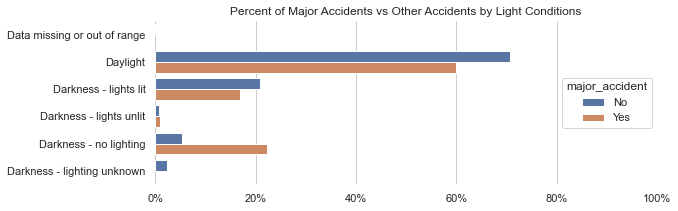

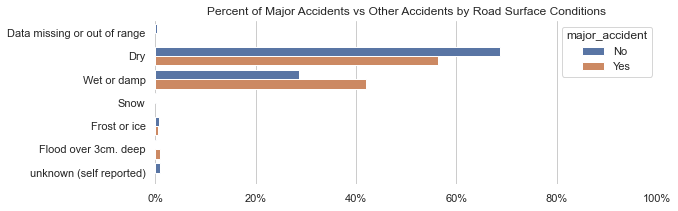

In [119]:
for condition,title in environment_dict.items():
    print("")
    plot_by_column(accidents,condition,title)  
    fig.savefig(title)

### Analysis by Infrastructure and Traffic Enforcement Conditions

In [105]:
infrastructure = ['urban_or_rural_area',
                  'first_road_class',
                  'second_road_class',
                  'road_type',
                  'junction_control',
                  'junction_detail',                  
                  'pedestrian_crossing_human_control',
                  'pedestrian_crossing_physical_facilities',
                  ]

In [106]:
chi_test_infrastructure = pd.DataFrame(columns =["Statistical value", "p value","Degrees of freedom"],index=infrastructure)

for column in infrastructure:
    chi_test_infrastructure.loc[column,:] = chi_test(accidents,column)
    
chi_test_infrastructure['Significance'] = np.where(chi_test_infrastructure['p value']<0.05,'p< 0.05 - we reject the null hypothesis','We cannot reject the null hypothesis')
chi_test_infrastructure

,Statistical value,p value,Degrees of freedom,Significance
urban_or_rural_area,174.839316,0.0,3,p< 0.05 - we reject the null hypothesis
first_road_class,8.727518,0.068283,4,We cannot reject the null hypothesis
second_road_class,24.883953,0.000053,4,p< 0.05 - we reject the null hypothesis
road_type,12.949811,0.011524,4,p< 0.05 - we reject the null hypothesis
junction_control,61.2613,0.0,4,p< 0.05 - we reject the null hypothesis
junction_detail,45.420413,0.0,4,p< 0.05 - we reject the null hypothesis
pedestrian_crossing_human_control,9.698873,0.045817,4,p< 0.05 - we reject the null hypothesis
pedestrian_crossing_physical_facilities,32.700112,0.000001,4,p< 0.05 - we reject the null hypothesis


In this case, most of the conditions related to infrastructure or traffic enforcement seem to be significantly associated with the occurence of a major vs other accident.
We'll plot them invidividually, to investigate further:

In [107]:
infrastructure_plots = ['urban_or_rural_area',
                  'second_road_class',
                  'road_type',
                  'junction_control',
                  'junction_detail',                  
                  'pedestrian_crossing_physical_facilities']
infrastructure_titles = ['Urban or Rural Area','Second Road Class','Road Type','Junction Control','Junction Detail','Pedestrian Crossing - Physical Facilities']
infrastructure_titles = ['Percent of Marjor Accidents vs.Other Accidents by ' + i for i in infrastructure_titles]
infrastructure_dict = dict(zip(infrastructure_plots,infrastructure_titles))

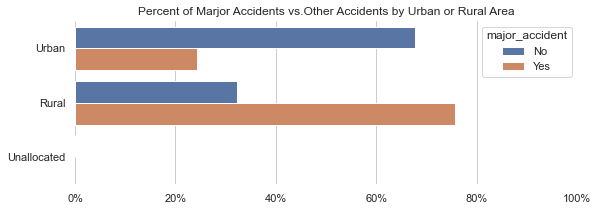

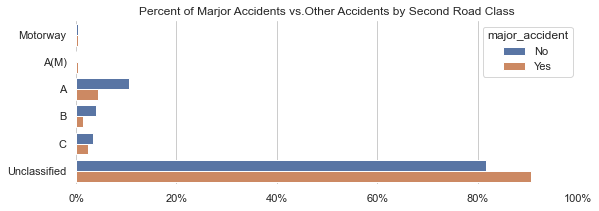

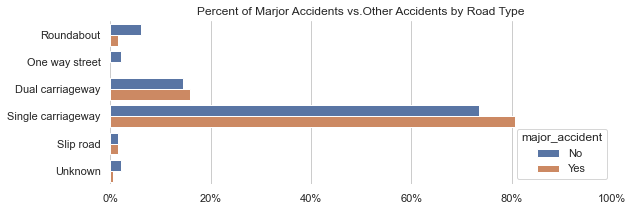

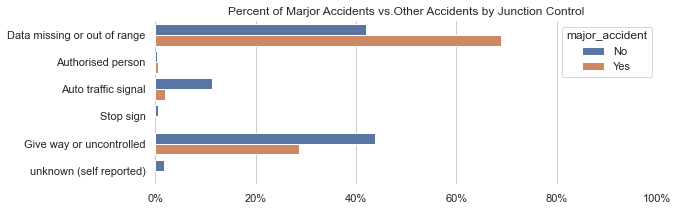

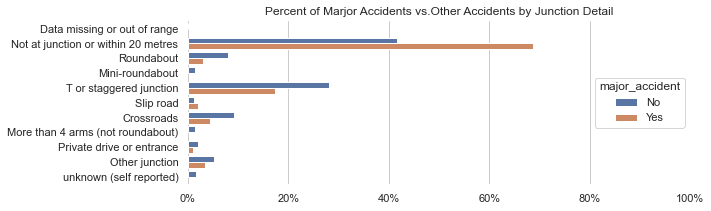

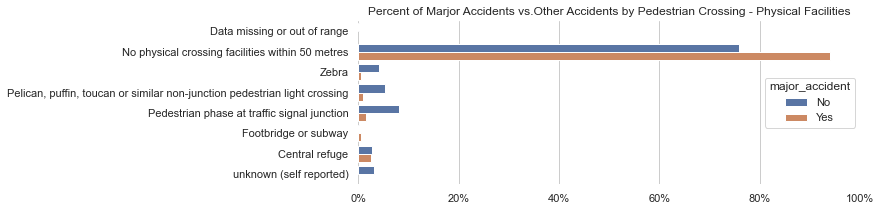

In [108]:
for condition,title in infrastructure_dict.items():
    print("")
    plot_by_column(accidents,condition,title)

We'll continue with the speed limit (non-categorical column, we couldn't include it in the plot above)

In [109]:
non_categorical = ['speed_limit']

In [110]:
chi_test_noncateg = pd.DataFrame(columns =["Statistical value", "p value","Degrees of freedom"],index=non_categorical)

for column in non_categorical:
    chi_test_noncateg.loc[column,:] = chi_test(accidents,column)
    
chi_test_noncateg['Significance'] = np.where(chi_test_noncateg['p value']<0.05,'p< 0.05 - we reject the null hypothesis','We cannot reject the null hypothesis')
chi_test_noncateg

,Statistical value,p value,Degrees of freedom,Significance
speed_limit,85.388263,0.0,4,p< 0.05 - we reject the null hypothesis


speed_limit


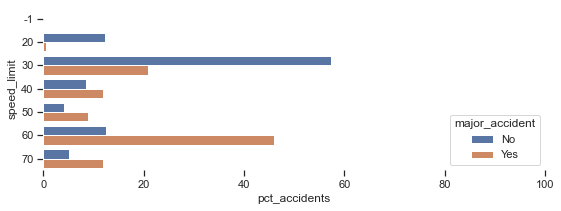

In [111]:
for condition in non_categorical:
    print(condition)
    plot_by_column_non_categ(accidents,condition)

### Analysis based on latitude and longitude

In [112]:
location_group = accidents.groupby(['latitude','longitude']).size().reset_index().rename(columns={0:'number_of_accidents'})

In [113]:
location_group.sort_values('number_of_accidents',ascending=False)

,latitude,longitude,number_of_accidents
80413,53.799708,-1.549110,4
83794,54.442582,-1.668508,3
76218,53.614316,-1.536725,3
29941,51.513673,-3.496256,3
47,50.107035,-5.295693,3
...,...,...,...
30370,51.516147,-0.009108,1
30369,51.516146,-0.301191,1
30368,51.516136,-2.520329,1
30367,51.516125,-2.667891,1


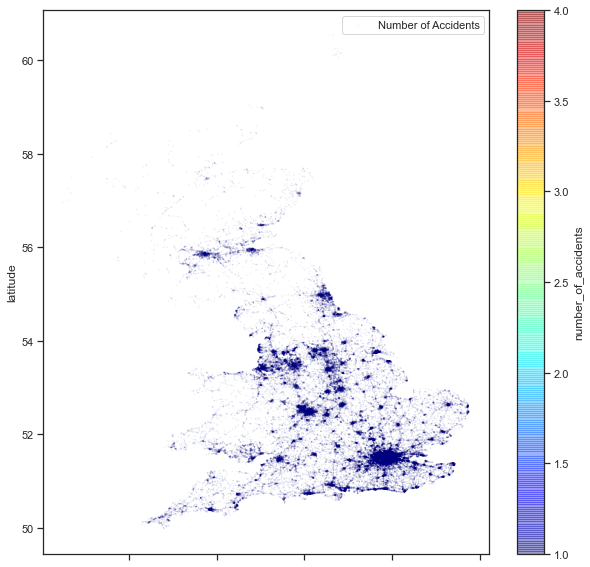

In [114]:
location_group.plot(kind="scatter", x="longitude", y="latitude", 
                   s=location_group.number_of_accidents/100,label="Number of Accidents",
                   c="number_of_accidents",cmap=plt.get_cmap("jet"),
                   colorbar=True,alpha=0.4,figsize=(10,10))
plt.legend()
plt.show()